# Optimize acoustic simulations

In [1]:
from matplotlib import pyplot as plt

from jaxdf.geometry import Domain
from jaxdf import operators as jops
from jaxdf.core import operator
from jax import numpy as jnp
import jax

The equation we want to simulate is

$$
\left(\nabla^2 + \frac{\omega^2}{c^2} \right)u = - i\omega S_M
$$

Furthermore, to enforce the Sommerfield radiation conditions, the components of the spatial differential operators are modified as [[1]](http://oomph-lib.maths.man.ac.uk/doc/pml_helmholtz/scattering/latex/refman.pdf):

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

where

$$
\gamma_j = 1 + \frac{i\sigma_j(x)}{k_0}, \qquad \sigma_j(x) = \begin{cases}
\frac{\sigma^*\Big| |x_j| - \Delta_{PML}\Big|^\alpha}{L/2-\Delta_{PML}}, & \|x\| > \Delta_{PML}\\
0, & \text{otherwise} \\
\end{cases}$$

## Domain

First, we need to define the domain where the PDE is solved. In the current version of the software, domains are always represented as scalings of the unit hyptercube centered at the origin. Furthermore, an intrinsic discretization also needs to be provided, which is only usd by grid-based methods, such as Finite Differences or Fourier spectral methods.

Let's define a domain implicitly using a grid of size $256 \times 256$ and $dx=1$

In [2]:
domain = Domain(N=(256, 256), dx=(1., 1.))


## A first operator

First, note that the $\sigma$ function has a direct dependence on the coordinate value. Therefore our first step is to define a `Coordinate` field whose value is equal to $\mathbf{x}$:

In [3]:
from jaxdf.discretization import Coordinate
from jaxdf.core import Field

# Define the field. Note that, obviously, it doesn't have any parameters
coordinate_discr = Coordinate(domain)
X = Field(coordinate_discr, params={}, name="x")
print(X)

Field :: Coordinate, x


The previous lines can be a bit obscure, but things will be clearer in a second. The important thing to remember is that `x` is an abstract field object that represents the coordinates.

To construct $\sigma$, let's start from its JAX-numpy implementation

In [4]:
def sigma(x):
    alpha = 2.
    sigma_star = 2.
    delta_pml = 110.
    L_half = 128.
    
    abs_x = jnp.abs(x)
    in_pml_amplitude = (jnp.abs(abs_x-delta_pml)/(L_half - delta_pml))**alpha
    return jnp.where(abs_x > delta_pml, sigma_star*in_pml_amplitude, 0.)

To transform this function into an operator, we use the `elementwise` constructor of `jaxdf`

In [5]:
Sigma = jops.elementwise(sigma)

We can apply this operator on an abstract field, by calling the `eval` method

In [6]:
from jaxdf.core import evaluate

y = evaluate(Sigma)(x=X)

`y` is now an discretized operator that contains two informations
1. The discretization of the output, in this case `Arbitrary`
2. The computations needed to go from the input field `x` to the output field (`_k5`): this this case, an `Elementwise` operation on the inputs

In [7]:
print(y)

DiscretizedOperator :: [Arbitrary], ['_k5'] 

 Input fields: ('x',)

Globals: Shared: {}
Independent: {}

Operations:
- _k5: Arbitrary <-- Elementwise ('x',) | (none) Elementwise



We can make this field concrete in two different ways. 

For the time being, let's get the value of the field at the grid nodes. Note that the output of `Sigma` is a vector field of two dimension, since the input field (a `Coordinate` field) is a vector field, so we plot the two components separately

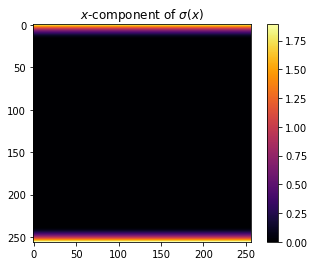

In [8]:
grid = y.get_field_on_grid(0)({},{'x':{}})  # This too will be clearer later

# Plot the field
plt.imshow(grid[...,0], cmap="inferno")
plt.title("$x$-component of $\sigma(x)$")
plt.colorbar()
plt.show()

## PML function 
We can now build on top of this new operator to construct more complex ones. In general, we can transform an arbitrary composition of operators described in a function using the `operator` decorator 

In [9]:
from jaxdf.core import operator

omega = 1.

def gamma(x):
    y = Sigma(x)
    return 1./(1. + 1j*y/omega)

Gamma = operator()(gamma) # Make it an operator

z = Gamma(x=X)
print(z)

DiscretizedOperator :: [Arbitrary], ['_x9'] 

 Input fields: ('x',)

Globals: Shared: {}
Independent: {'MultiplyScalar_l5': {'scalar': 1j}, 'DivideByScalar_nR': {'scalar': 1.0}, 'AddScalar_p2': {'scalar': 1.0}, 'MultiplyScalar_wR': {'scalar': 1.0}}

Operations:
- _k5: Arbitrary <-- Elementwise ('x',) | (none) Elementwise
- _mO: Arbitrary <-- MultiplyScalar ('_k5',) | (independent) MultiplyScalar_l5
- _oj: Arbitrary <-- DivideByScalar ('_mO',) | (independent) DivideByScalar_nR
- _q2: Arbitrary <-- AddScalar ('_oj',) | (independent) AddScalar_p2
- _vm: Arbitrary <-- Reciprocal ('_q2',) | (none) Reciprocal
- _x9: Arbitrary <-- MultiplyScalar ('_vm',) | (independent) MultiplyScalar_wR



This operator has a more complex computational graph. 

Note also that now there are a bunch of numerical parameters after `Independent`: those are parameters required by the computational graph used to transform the discrete representation. 

The reason why they are explicitly stated, rather than hidden in the computational graph, is that treating them as input variables allows to perform program transformations (such as autodiff) with respect to them as well. This is further explained in the Tutorial XXX

For the time being, we will just collect those parameters using the `get_global_params()` method and remember to provide them as inputs.

In [10]:
global_params = z.get_global_params()

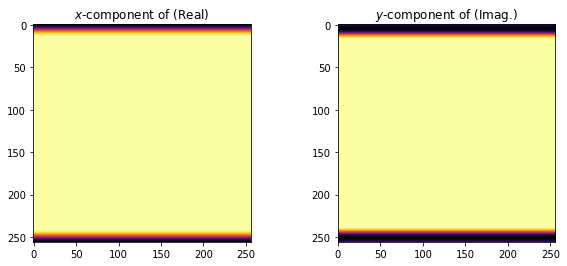

In [11]:
pml_on_grid = z.get_field_on_grid(0)(global_params, {'x': {}})

# Plot the field
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].imshow(pml_on_grid[...,0].real, cmap="inferno")
ax[0].set_title("$x$-component of (Real)")
ax[1].imshow(pml_on_grid[...,0].imag, cmap="inferno")
ax[1].set_title("$y$-component of (Imag.)")
plt.show()

## Modified Laplacian operator

The next step is to define the Laplacian operatr $\nabla^2\$ using the modified derivatives

$$
\partial_{x_j} = \frac{\partial_{x_j}}{\gamma_j}
$$

That is, we need to define a function over an input field $u$ that evaluates

$$
\sum_{j=\{x,y\}} \frac{\partial_{x_j}}{\gamma_j} \left( \frac{\partial_{x_j}}{\gamma_j} u \right)
$$

**⚠️ Experimental feature** Note that the previously defined function `gamma` has a different discretization than the one we use for the input field. To transform the `pml` function into the same representation as `u`, we use a projection operator.

In [12]:
def laplacian(u, x):
    pml = gamma(x)  # previously defined function
    pml = jops.project(into=u, field=pml) # Project into the discretization of u
    grad_u = jops.gradient(u)
    mod_grad_u = grad_u*pml
    mod_diag_jacobian = jops.diag_jacobian(mod_grad_u)*pml
    return jops.sum_over_dims(mod_diag_jacobian)

To make this operator concrete, we need to define a discretization for the `u` variable. This discretization must support the `gradient`, `diag_jacobian` and `sum_over_dims`.

We'll use a Fourier Series discretization, which implements Fourier spectral methods for the various operators.

In [13]:
from jaxdf.discretization import FourierSeries

# Initialize discretizations
fourier_discr = FourierSeries(domain)

# Initialize parameters (we already have the PML parameters)
u_fourier_params, u = fourier_discr.empty_field(name='u')
u_fourier_params = u_fourier_params.at[128,128].set(1.)

In [14]:
u.discretization.get_field_on_grid()(u_fourier_params).shape

(256, 256, 1)

In [15]:
L = operator()(laplacian)(u=u, x=X)

In [16]:
global_params = L.get_global_params()
lapl = L.get_field_on_grid(0)

In [17]:
print(L)

DiscretizedOperator :: [FourierSeries], ['_N6'] 

 Input fields: ('u', 'x')

Globals: Shared: {'k_vec': [DeviceArray([ 0.        ,  0.02454369,  0.04908739,  0.07363108,
              0.09817477,  0.12271847,  0.14726216,  0.17180586,
              0.19634955,  0.22089323,  0.24543694,  0.26998064,
              0.2945243 ,  0.319068  ,  0.34361172,  0.3681554 ,
              0.3926991 ,  0.4172428 ,  0.44178647,  0.46633017,
              0.49087387,  0.5154176 ,  0.5399613 ,  0.5645049 ,
              0.5890486 ,  0.6135923 ,  0.638136  ,  0.66267973,
              0.68722343,  0.7117671 ,  0.7363108 ,  0.7608545 ,
              0.7853982 ,  0.8099419 ,  0.8344856 ,  0.8590293 ,
              0.88357294,  0.90811664,  0.93266034,  0.95720404,
              0.98174775,  1.0062914 ,  1.0308352 ,  1.0553788 ,
              1.0799226 ,  1.1044662 ,  1.1290098 ,  1.1535536 ,
              1.1780972 ,  1.202641  ,  1.2271847 ,  1.2517284 ,
              1.276272  ,  1.3008157 ,  1.3253595 

## Helmholtz operator

In [18]:
@operator()
def helmholtz(u, c, x):
    # Get the modified laplacian
    L = laplacian(u, x)
    
    # Add the wavenumber term
    k = ((omega/c)**2)*u
    
    return L + k

Let's make the operator concrete by specifying the discretizations

In [19]:
from jaxdf.discretization import FourierSeries

# Initialize discretizations
fourier_discr = FourierSeries(domain)

# Initialize parameters (we already have the PML parameters)
u_fourier_params, u = fourier_discr.empty_field(name='u')

src_fourier_params, src = fourier_discr.empty_field(name='src')
src_fourier_params = u_fourier_params.at[128, 40].set(1. + 0j)  # Source field, using Fourier discretization

c_fourier_params, c = fourier_discr.empty_field(name='c')
c_fourier_params = c_fourier_params + 1.                      # Uniform SoS of 1.
c_fourier_params = c_fourier_params.at[20:40,20:100].set(2.)
c_fourier_params = c_fourier_params.at[20:200,150:200].set(1.5)

x = Field(fourier_discr, params=pml_on_grid, name='pml')
x_params = grid

In [20]:
# Make the computational graph
Hu = helmholtz(u=u, c=c, x=X)
global_params = Hu.get_global_params()

def helm_func(u):
    return Hu.get_field_on_grid(0)(
        global_params,
        {"u":u, "c":c_fourier_params, "x":x_params}
    )

In [21]:
helm_func(u_fourier_params).shape

(256, 256, 1)

The operator is now discretized, and we can apply it on an input field using `Hu.get_field_on_grid(0)`

### Solving with GMRES

Because both our representation and the Helmholtz operator are linear, we can solve for the input field using numerical solvers for linear systems, such as GMRES.
We can't do that with respect to he speed of sound, since the output depends non-linearly from it

In [35]:
from jax.scipy.sparse.linalg import gmres
from functools import partial

sol, _ = gmres(helm_func, src_fourier_params, maxiter=1000)

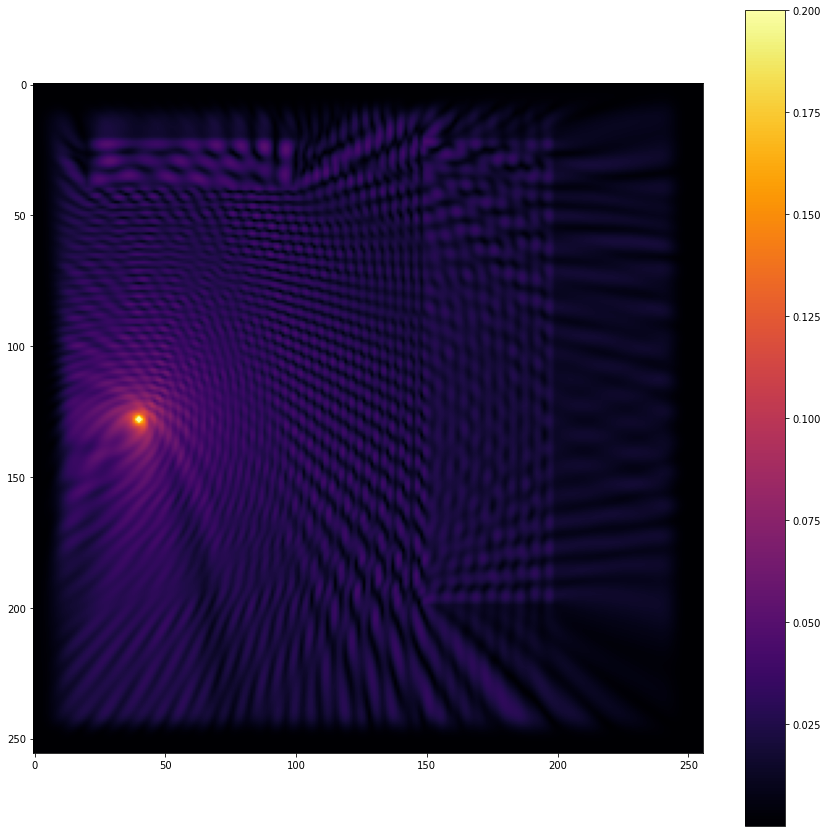

In [23]:
plt.figure(figsize=(15,15))
plt.imshow(jnp.abs(sol), cmap="inferno", vmax=.2)
plt.colorbar()

## Optimise the speed of sound of a lens

The following code reproduces the example in the NeurIPS paper. It finds a lens to focus an acoustic source on a target, using gradient descent

In [24]:
def join_dicts(dict1, dict2):
    for k, v in dict2.items():
        if k in dict1:
            continue
        else:
            dict1[k] = v
    return dict1

@operator()
def total_variation(u):
    nabla_u = jops.gradient(u)    
    return jops.sum_over_dims(jops.elementwise(jnp.abs)(nabla_u))

TV = total_variation(u=u)
global_params = join_dicts(global_params, TV.get_global_params())
tv_on_grid = TV.get_field_on_grid(0)

tv_fun = lambda u: tv_on_grid(global_params, {"u": u})

In [25]:
from jax import random

seed = random.PRNGKey(32)
x_coord = grid[...,0]
y_coord = grid[...,1]
lens_params = random.uniform(seed, (168,40))-4

def get_sos(T):
    lens = jnp.zeros(domain.N)
    lens = lens.at[44:212,108:148].set(jax.nn.sigmoid(T)) + 1
    return jnp.expand_dims(lens, -1)

f = Hu.get_field_on_grid(0)

def find_field(sos, guess = None):
    params = {"c":sos, "pml":pml_on_grid}
    
    def H(u):
        params["u"] = u
        return f(global_params, params)
    
    sol, _ = gmres(H, src_fourier_params, x0=guess, maxiter=1000, tol=1e-3, restart=10)
    return sol

def loss(p, guess):
    sos = get_sos(p)
    tv_term = jnp.mean(tv_fun(sos))
    field = find_field(sos, guess=guess)
    return -jnp.sum(jnp.abs(field[70,210])) + tv_term, field

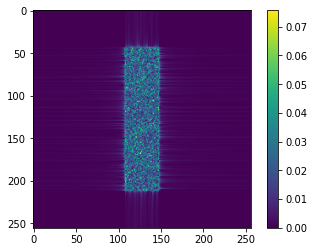

In [26]:
sos_func = get_sos(lens_params)
plt.imshow(tv_fun(sos_func))
plt.colorbar()

In [27]:
from jax.example_libraries import optimizers
from jax import jit
from tqdm import tqdm

losshistory = []

init_fun, update_fun, get_params = optimizers.adam(.1, b1=0.9, b2=0.9)
opt_state = init_fun(lens_params)

@jit
def update(opt_state, field):
    loss_and_field, gradient = jax.value_and_grad(loss, has_aux=True)(get_params(opt_state), field)
    return loss_and_field[0], loss_and_field[1], update_fun(k, gradient, opt_state)

pbar = tqdm(range(100))
field = -src_fourier_params
for k in pbar:
    lossval, field, opt_state = update(opt_state, field)
    # For logging
    pbar.set_description("Ampl: {:01.4f}".format(-lossval))
    losshistory.append(lossval)
    
transmit_phase = get_params(opt_state)

Ampl: 0.1155: 100%|██████████| 100/100 [02:44<00:00,  1.64s/it]


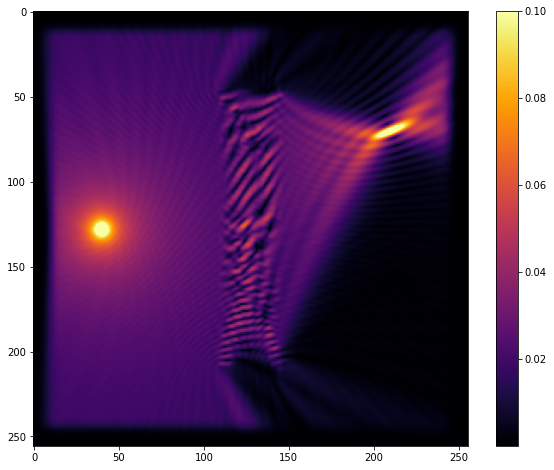

In [28]:
optimal_field = find_field(get_sos(get_params(opt_state)))
plt.figure(figsize=(10,8))
plt.imshow(jnp.abs(optimal_field), cmap="inferno", vmax=.1)
plt.colorbar()

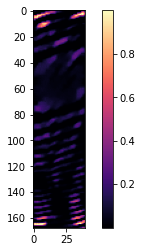

In [29]:
plt.imshow(jax.nn.sigmoid(get_params(opt_state)), cmap="magma")
plt.colorbar()

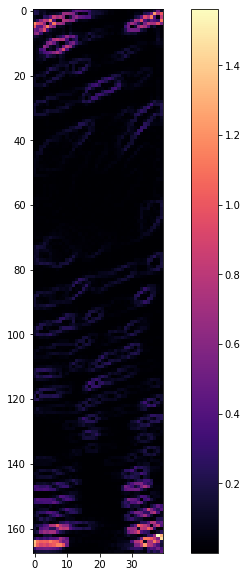

In [30]:
plt.figure(figsize=(10,10))
sos_func = get_sos(get_params(opt_state))
plt.imshow(tv_fun(sos_func)[44:212,108:148], cmap="magma")
plt.colorbar()

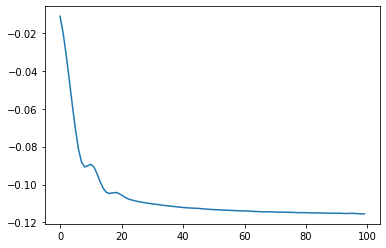

In [31]:
plt.plot(losshistory)

In [32]:
import matplotlib

(-0.5, 39.5, 167.5, -0.5)

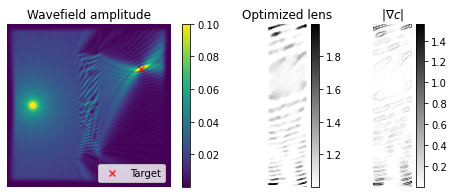

In [33]:
fig, ax = plt.subplots(1,3,figsize=(8,3), gridspec_kw={'width_ratios': [3, 1, 1]})

im1 = ax[0].imshow(jnp.abs(optimal_field), cmap="viridis", vmax=.1)
ax[0].axis("off")
ax[0].scatter(210,70, marker='x', color="red", label="Target", alpha=0.8)
plt.colorbar(im1, ax=ax[0])
ax[0].set_title("Wavefield amplitude")
ax[0].legend(loc="lower right")

sos_opt = get_sos(get_params(opt_state))
im2 = ax[1].imshow(sos_opt[44:212,108:148], cmap="binary")
plt.colorbar(im2, ax=ax[1])
ax[1].set_title("Optimized lens")
ax[1].axis("off")

im3 = ax[2].imshow(tv_fun(sos_opt)[44:212,108:148], cmap="binary")
plt.colorbar(im3, ax=ax[2])
ax[2].set_title("$\\|\\nabla c\\|$")
ax[2].axis("off")

#plt.savefig('img/optimized_lens.pgf')